**Setup object detection network**

Clone repo, install dependencies.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 10839, done.
remote: Total 10839 (delta 0), reused 0 (delta 0), pack-reused 10839
Receiving objects: 100% (10839/10839), 10.92 MiB | 27.68 MiB/s, done.
Resolving deltas: 100% (7489/7489), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


**Loading YOLO-v5 Model**

In [2]:
import torch

# Loading the YOLO v5 model
model_obj = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-4 torch 1.10.0+cu111 CPU



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


**Fixing a minor bug in visualizing the images**

The snippet code below is to fix a bug usualyy encountered after running the above code. We uninstall the matplotlib and then reinstall the inline version.

In [3]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3
%matplotlib inline

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.2.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.2.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib.libs/libpng16-cfdb1654.so.16.21.0
    /usr/local/lib/python3.7/dist-packages/matplotlib.libs/libz-a147dcb0.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.2.2
     |████████████████████████████████| 13.1 MB 10.1 MB/s 
ERROR: pip's dependency r

**Image Utils**

In [4]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from torchvision import transforms


HEIGHT = 256
WIDTH = 320


def scale_image(img, scale=None):
    """Resize/scale an image. If a scale is not provided, scale it closer to HEIGHT x WIDTH."""
    # if scale is None, scale to the longer size
    if scale is None:
        scale = max(WIDTH / img.shape[1], HEIGHT / img.shape[0])

    new_size = (math.ceil(img.shape[1] * scale), math.ceil(img.shape[0] * scale))
    image = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    return image


def center_crop(img):
    """Center crop an image to HEIGHT x WIDTH."""
    corner = ((img.shape[0] - HEIGHT) // 2, (img.shape[1] - WIDTH) // 2)
    img = img[corner[0]:corner[0] + HEIGHT, corner[1]:corner[1] + WIDTH]
    return img


def img_transform(img):
    """Normalize an image."""
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = data_transform(img)
    return img


def show_img_and_pred(img, depth):
    """Plot an image and a corresponding prediction next to each other."""
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    pred = np.transpose(depth, (1, 2, 0))
    plt.imshow(pred[:, :, 0])
    plt.show()


def depth_to_grayscale(depth, max_dist=10.0):
    """Transform a prediction into a grayscale 8-bit image."""
    depth = np.transpose(depth, (1, 2, 0))
    depth[depth > max_dist] = max_dist
    depth = depth / max_dist

    depth = np.array(depth * 255.0, dtype=np.uint8)
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    bgr_depth_img = cv2.cvtColor(depth, cv2.COLOR_GRAY2BGR)
    bgr_depth_img = np.clip(bgr_depth_img, 0, 255)
    return bgr_depth_img

**Depth estimation model**

In [5]:
import torch.nn as nn
import torch
import os


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 conv layer with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_incoming_shape(incoming):
    size = incoming.size()
    # returns the incoming data shape as a list
    return [size[0], size[1], size[2], size[3]]


def interleave(tensors, axis):
    # change the first element (batch_size to -1)
    old_shape = get_incoming_shape(tensors[0])[1:]
    new_shape = [-1] + old_shape

    # double 1 dimension
    new_shape[axis] *= len(tensors)

    # pack the tensors on top of each other
    stacked = torch.stack(tensors, axis+1)

    # reshape and return
    reshaped = stacked.view(new_shape)
    return reshaped


class UnpoolingAsConvolution(nn.Module):
    def __init__(self, inplanes, planes):
        super(UnpoolingAsConvolution, self).__init__()

        # interleaving convolutions
        self.conv_A = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 3), stride=1, padding=1)
        self.conv_B = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 3), stride=1, padding=0)
        self.conv_C = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 2), stride=1, padding=0)
        self.conv_D = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(2, 2), stride=1, padding=0)

    def forward(self, x):
        output_a = self.conv_A(x)

        padded_b = nn.functional.pad(x, (1, 1, 0, 1))
        output_b = self.conv_B(padded_b)

        padded_c = nn.functional.pad(x, (0, 1, 1, 1))
        output_c = self.conv_C(padded_c)

        padded_d = nn.functional.pad(x, (0, 1, 0, 1))
        output_d = self.conv_D(padded_d)

        left = interleave([output_a, output_b], axis=2)
        right = interleave([output_c, output_d], axis=2)
        y = interleave([left, right], axis=3)
        return y


class UpProjection(nn.Module):
    def __init__(self, inplanes, planes):
        super(UpProjection, self).__init__()

        self.unpool_main = UnpoolingAsConvolution(inplanes, planes)
        self.unpool_res = UnpoolingAsConvolution(inplanes, planes)

        self.main_branch = nn.Sequential(
            self.unpool_main,
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=False),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(planes)
        )

        self.residual_branch = nn.Sequential(
            self.unpool_res,
            nn.BatchNorm2d(planes),
        )

        self.relu = nn.ReLU(inplace=False)

    def forward(self, input_data):
        x = self.main_branch(input_data)
        res = self.residual_branch(input_data)
        x += res
        x = self.relu(x)
        return x


class ConConv(nn.Module):
    def __init__(self, inplanes_x1, inplanes_x2, planes):
        super(ConConv, self).__init__()
        self.conv = nn.Conv2d(inplanes_x1 + inplanes_x2, planes, kernel_size=1, bias=True)

    def forward(self, x1, x2):
        x1 = torch.cat([x2, x1], dim=1)
        x1 = self.conv(x1)
        return x1


class ResnetUnetHybrid(nn.Module):
    def __init__(self, block, layers):
        self.inplanes = 64

        # resnet layers
        super(ResnetUnetHybrid, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # additional up projection layers parts
        self.conv2 = nn.Conv2d(2048, 1024, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(1024)

        self.up_proj1 = UpProjection(1024, 512)
        self.up_proj2 = UpProjection(512, 256)
        self.up_proj3 = UpProjection(256, 128)
        self.up_proj4 = UpProjection(128, 64)

        self.drop = nn.Dropout(0.5, False)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=True)

        # padding + concat for unet stuff
        self.con_conv1 = ConConv(1024, 512, 512)
        self.con_conv2 = ConConv(512, 256, 256)
        self.con_conv3 = ConConv(256, 128, 128)
        self.con_conv4 = ConConv(64, 64, 64)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x_to_conv4 = self.relu(x)

        x = self.maxpool(x_to_conv4)
        x_to_conv3 = self.layer1(x)
        x_to_conv2 = self.layer2(x_to_conv3)
        x_to_conv1 = self.layer3(x_to_conv2)
        x = self.layer4(x_to_conv1)

        # additional layers
        x = self.conv2(x)
        x = self.bn2(x)

        # up project part
        x = self.up_proj1(x)
        x = self.con_conv1(x, x_to_conv1)

        x = self.up_proj2(x)
        x = self.con_conv2(x, x_to_conv2)

        x = self.up_proj3(x)
        x = self.con_conv3(x, x_to_conv3)

        x = self.up_proj4(x)
        x = self.con_conv4(x, x_to_conv4)

        x = self.drop(x)
        x = self.conv3(x)
        x = self.relu(x)

        return x

    @classmethod
    def load_pretrained(cls, device, load_path='hyb_net_weights.model'):
        model = cls(Bottleneck, [3, 4, 6, 3])

        # download the weights if they are not present
        if not os.path.exists(load_path):
            print('Downloading model weights...')
            os.system('wget https://www.dropbox.com/s/amad4ko9opi4kts/hyb_net_weights.model')

        model = model.to(device)
        model.load_state_dict(torch.load(load_path, map_location=device))

        return model

**Loading The Hybrid CNN Depth Estimation Model**

In [6]:
# switch to CUDA device if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Use GPU: {}'.format(str(device) != 'cpu'))

# load model
print('Loading model...')
model_dep = ResnetUnetHybrid.load_pretrained(device=device)
model_dep.eval()

Use GPU: False
Loading model...


ResnetUnetHybrid(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

**Feeding input image to object detection**

By running the snippet code below, the user is required to enter the URL address of where their image is saved. The image is then passed to the YOLO model and the output is saved for further processings.

In [126]:
%rm -rf runs
# The user is asked to enetr the url address of where the image is saved
img_path = input("Please Enter Image Path: ")  

# Inference
results = model_obj(img_path)
# Initiating some blank space for more clearity
def clear():
    print('\n' * 5)
clear()
# Fetching the output results
results.xyxy[0]  # im predictions (tensor)
res= results.pandas().xyxy[0]  # im predictions (pandas)
print('\033[1m'+'The coordinates of the output bonding boxes and the detection results: \n', res.values) # printing the output of object detection network
results.save() # saving the output

Please Enter Image Path: /content/rgb_1_0.png


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to runs/detect/exp








The coordinates of the output bonding boxes and the detection results: 
 [[175.57542419433594 331.2414245605469 320.66741943359375 471.3099670410156 0.7549963593482971 56 'chair']
 [457.1634521484375 167.70281982421875 534.976806640625 243.53567504882812 0.5607364177703857 68 'microwave']
 [592.451904296875 154.85301208496094 632.6588134765625 480.0 0.4889179766178131 72 'refrigerator']
 [431.96246337890625 284.90338134765625 598.7720336914062 469.49554443359375 0.34165069460868835 69 'oven']]


**Acquiring the bounding boxes generated by object detector**

In [127]:
from PIL import Image
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt

# Getting the user image info
image___= Image.open(img_path)
image = asarray(image___)
print('Input image size: ', image.shape)
obj,ins= res.shape
boxes= []
# The coordinates of bounding boxes will be stored in the following variables
xmin= np.zeros((obj,1))
ymin= np.zeros((obj,1))
xmax= np.zeros((obj,1))
ymax= np.zeros((obj,1))
# Storing the bounding box coordinates of each detected object 
for i in range(obj):
  xmin_temp= np.int(res.values[i,0])
  xmin[i]= xmin_temp
  ymin_temp= np.int(res.values[i,1])
  ymin[i]= ymin_temp
  xmax_temp= np.int(res.values[i,2])
  xmax[i]= xmax_temp
  ymax_temp= np.int(res.values[i,3])
  ymax[i]= ymax_temp
  box= image[ymin_temp:ymax_temp,xmin_temp:xmax_temp,:]
  boxes.append(box)

Input image size:  (480, 640, 3)


**Feed the bounding boxes to the depth estimation network**

In [128]:
import argparse
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib

#from network import ResnetUnetHybrid
#import image_utils


def predict_img(img):
    """Inference a single image."""

    # load image
    img = scale_image(img)
    img = center_crop(img)
    inp = img_transform(img)
    inp = inp[None, :, :, :].to(device)

    # inference
    print('Running the image through the network...')
    output = model_dep(inp)

    # transform and plot the results
    output = output.cpu()[0].data.numpy()
    #show_img_and_pred(img, output)
    return output

median_criterion_out= np.zeros((obj,1))
median_distance= np.zeros((obj,1))
mean_criterion_out= np.zeros((obj,1))
mean_distance= np.zeros((obj,1))
def depth_inference(boxes,max_depth):
  for i in range(obj):
    output= predict_img(boxes[i])
    # depth inference per bounding box through median criterion 
    median= np.median(output)
    print('med',median)
    median_distance[i]= median
    if median<= max_depth:
      median_criterion_out[i]=1
    # depth inference per bounding box through median criterion 
    d,w,h= output.shape
    box_center= output[:,np.int(w/2-0.2*w):np.int(w/2+0.2*w),np.int(h/2-0.2*h):np.int(h/2+0.2*h)]
    mean= np.mean(box_center)
    mean_distance[i]= mean
    if mean<= max_depth:
      mean_criterion_out[i]=1
  return median_criterion_out, mean_criterion_out, median_distance, mean_distance

# inference
max_depth= float(input("Maximum Object Depth: "))
median_criterion, mean_criterion, median_distance, mean_distance= depth_inference(boxes,max_depth)
print(median_criterion)
print(mean_criterion)

Maximum Object Depth: 1
Running the image through the network...
med 0.7986909
Running the image through the network...
med 1.0755644
Running the image through the network...
med 0.9880929
Running the image through the network...
med 0.8617412
[[          1]
 [          0]
 [          1]
 [          1]]
[[          1]
 [          0]
 [          1]
 [          1]]


**Joint network outcome with median criterion**

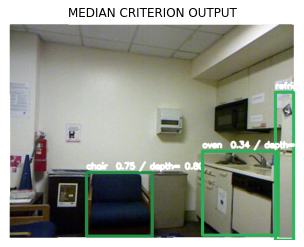

In [129]:
# Getting the user image info
image___= Image.open(img_path)
image = asarray(image___)
for i in range(obj):
  detected_targets=0
  if median_criterion[i]:
    detected_targets= detected_targets+1
    col= (np.int(res.values[i,5])+1)*10
    #print(col)
    c= cv2.rectangle(image, (np.int(xmin[i]), np.int(ymin[i])), (np.int(xmax[i]), np.int(ymax[i])), (col/16,col/4,col/8), 5)
    b= cv2.putText(c,str(res.values[i,6])+'  '+"{:.2f}".format(res.values[i,4])+' / depth= '+"{:.2f}".format(np.float(median_distance[i])),(np.int(xmin[i]),np.int(ymin[i])-8),0,0.6,(255,255,255),4)
if detected_targets !=0:
  median_pic= b
  plt.imshow(b)
  plt.axis('off')
  plt.title('MEDIAN CRITERION OUTPUT')
  #print(b.shape)
else:
  median_pic= image
  plt.imshow(image)
  plt.axis('off')
  plt.title('No Object closer than the range you entered , was detected with median criterion!')

im = Image.fromarray(image)
im.save("/content/joint_depth_object_median.png")

**Joint network outcome with median criterion**

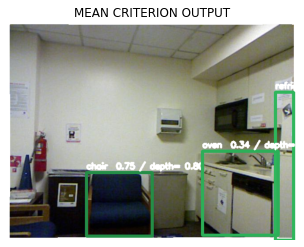

In [130]:
# Getting the user image info
image___= Image.open(img_path)
image = asarray(image___)
#print(image.shape)
for i in range(obj):
  detected_targets=0
  if mean_criterion[i]:
    detected_targets= detected_targets+1
    col= (np.int(res.values[i,5])+1)*10
    #print(col)
    c= cv2.rectangle(image, (np.int(xmin[i]), np.int(ymin[i])), (np.int(xmax[i]), np.int(ymax[i])), (col/16,col/4,col/8), 5)
    b= cv2.putText(c,str(res.values[i,6])+'  '+"{:.2f}".format(res.values[i,4])+' / depth= '+"{:.2f}".format(np.float(median_distance[i])),(np.int(xmin[i]),np.int(ymin[i])-8),0,0.6,(255,255,255),4)
if detected_targets !=0:
  mean_pic= b
  plt.imshow(b)
  plt.axis('off')
  plt.title('MEAN CRITERION OUTPUT')
  #print(b.shape)
else:
  mean_pic= image
  plt.imshow(image)
  plt.axis('off')
  plt.title('No Object closer than the range you entered , was detected with mean criterion!')

im = Image.fromarray(image)
im.save("/content/joint_depth_object_mean.png")

**Visulaizing The Outputs**

/content/runs/detect/exp/rgb_1_0.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


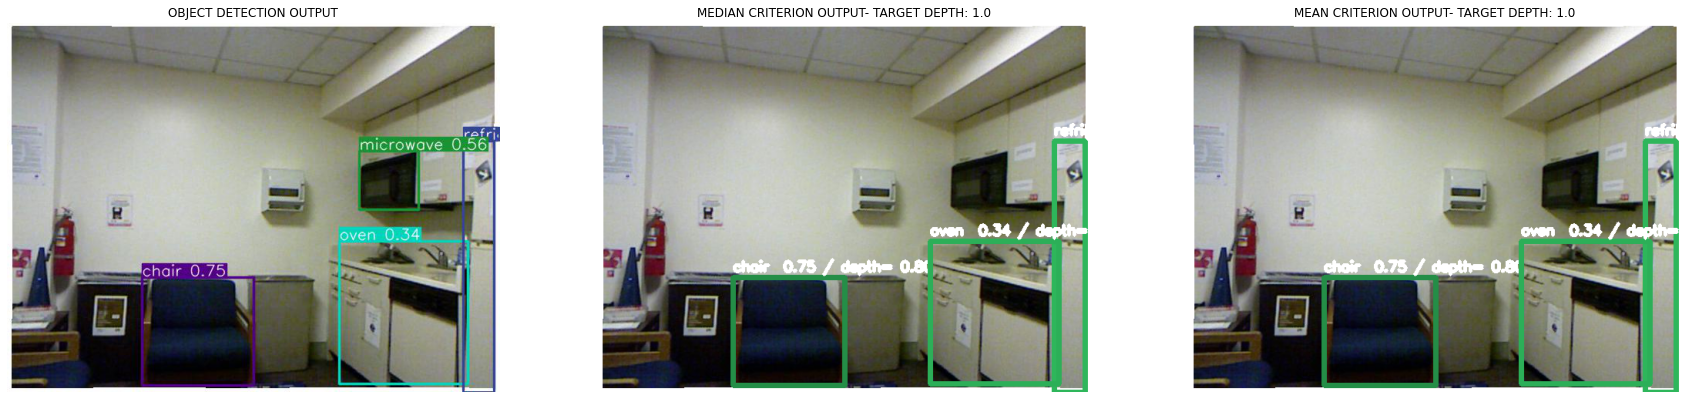

In [131]:
# fetching the outpot of YOLO-v5
x = img_path.split("/")
x_last= x[-1]
y= x_last.split(".")
yolo_path= '/content/runs/detect/exp/'+y[0]+'.jpg'
print(yolo_path)
# visualizing all the outputs
image___= Image.open(yolo_path)
image_yolo = asarray(image___) 

fig, axs = plt.subplots(1, 3)

axs[0].imshow(image_yolo)
axs[1].imshow(median_pic)
axs[2].imshow(mean_pic)

axs[0].set_title("OBJECT DETECTION OUTPUT")
axs[1].set_title("MEDIAN CRITERION OUTPUT- TARGET DEPTH: "+ str(max_depth))
axs[2].set_title("MEAN CRITERION OUTPUT- TARGET DEPTH: "+ str(max_depth))

[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()
fig.set_size_inches(30, 30)